In [2]:
import os
import cv2
import numpy as np
from scipy.io import loadmat

# Paths
src = "/kaggle/input/egohands/_LABELLED_SAMPLES"
dst = "/kaggle/working/processed_egohands"
os.makedirs(dst, exist_ok=True)

class_count = 0

for session_folder in sorted(os.listdir(src)):
    session_path = os.path.join(src, session_folder)
    if not os.path.isdir(session_path):
        continue

    mat_path = os.path.join(session_path, 'polygons.mat')
    if not os.path.exists(mat_path):
        continue

    # Load .mat content
    mat = loadmat(mat_path)
    polygons = mat['polygons'][0]

    # ✅ Sort frame files alphabetically
    frame_files = sorted([
        f for f in os.listdir(session_path)
        if f.endswith('.jpg') and f.startswith('frame_')
    ])

    if len(polygons) != len(frame_files):
        print(f"⚠️ Skipping {session_folder}: mismatch {len(polygons)} polygons vs {len(frame_files)} frames")
        continue

    print(f"\n📁 Session: {session_folder} — {len(polygons)} matched frames")

    # Take first 20 matched items
    selected = list(zip(polygons, frame_files))[:20]
    class_dir = os.path.join(dst, f'class_{class_count:02d}')
    os.makedirs(class_dir, exist_ok=True)

    for j, (polygon, frame_name) in enumerate(selected):
        image_path = os.path.join(session_path, frame_name)
        image = cv2.imread(image_path)
        if image is None:
            continue

        # Save RGB
        cv2.imwrite(os.path.join(class_dir, f'img_{j:03d}.jpg'), image)

        # Create binary mask
        height, width = image.shape[:2]
        mask = np.zeros((height, width), dtype=np.uint8)
        for annot in polygon:
            if annot.size > 0:
                pts = annot.reshape(-1, 1, 2).astype(np.int32)
                cv2.fillPoly(mask, [pts], color=255)

        # Save mask
        cv2.imwrite(os.path.join(class_dir, f'mask_{j:03d}.png'), mask)
        print(f"✅ {frame_name} → img_{j:03d}.jpg + mask_{j:03d}.png")

    class_count += 1
    if class_count >= 50:
        break

print("\n✅ Step 1 complete: RGB + mask pairs saved to /kaggle/working/processed_egohands/")



📁 Session: CARDS_COURTYARD_B_T — 100 matched frames
✅ frame_0011.jpg → img_000.jpg + mask_000.png
✅ frame_0036.jpg → img_001.jpg + mask_001.png
✅ frame_0099.jpg → img_002.jpg + mask_002.png
✅ frame_0113.jpg → img_003.jpg + mask_003.png
✅ frame_0176.jpg → img_004.jpg + mask_004.png
✅ frame_0183.jpg → img_005.jpg + mask_005.png
✅ frame_0184.jpg → img_006.jpg + mask_006.png
✅ frame_0187.jpg → img_007.jpg + mask_007.png
✅ frame_0189.jpg → img_008.jpg + mask_008.png
✅ frame_0206.jpg → img_009.jpg + mask_009.png
✅ frame_0229.jpg → img_010.jpg + mask_010.png
✅ frame_0241.jpg → img_011.jpg + mask_011.png
✅ frame_0295.jpg → img_012.jpg + mask_012.png
✅ frame_0316.jpg → img_013.jpg + mask_013.png
✅ frame_0324.jpg → img_014.jpg + mask_014.png
✅ frame_0333.jpg → img_015.jpg + mask_015.png
✅ frame_0381.jpg → img_016.jpg + mask_016.png
✅ frame_0384.jpg → img_017.jpg + mask_017.png
✅ frame_0484.jpg → img_018.jpg + mask_018.png
✅ frame_0580.jpg → img_019.jpg + mask_019.png

📁 Session: CARDS_COURTYARD

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class EgoHandsSegmentationDataset(Dataset):
    def __init__(self, root_dir, image_size=(256, 256)):
        self.samples = []
        self.image_size = image_size
        self.transform_img = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # standard ImageNet mean/std
                                 std=[0.229, 0.224, 0.225])
        ])

        self.transform_mask = transforms.Compose([
            transforms.Resize(image_size, interpolation=Image.NEAREST)
        ])

        for class_dir in sorted(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_dir)
            if not os.path.isdir(class_path):
                continue

            # Collect image-mask pairs
            for file in os.listdir(class_path):
                if file.startswith("img_") and file.endswith(".jpg"):
                    index = file.split("_")[1].split(".")[0]
                    mask_name = f"mask_{index}.png"
                    mask_path = os.path.join(class_path, mask_name)
                    img_path = os.path.join(class_path, file)
                    if os.path.exists(mask_path):
                        self.samples.append((img_path, mask_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = self.transform_img(image)
        mask = self.transform_mask(mask)
        mask = torch.from_numpy(np.array(mask)).long()
        mask = mask // 255  # convert 255 → 1 (binary class)

        return image, mask


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 — Train Loss: 0.2282 — Val Loss: 0.1157
Epoch 2/10 — Train Loss: 0.0784 — Val Loss: 0.0592
Epoch 3/10 — Train Loss: 0.0538 — Val Loss: 0.1467
Epoch 4/10 — Train Loss: 0.0441 — Val Loss: 0.1577
Epoch 5/10 — Train Loss: 0.0410 — Val Loss: 0.0402
Epoch 6/10 — Train Loss: 0.0339 — Val Loss: 0.0439
Epoch 7/10 — Train Loss: 0.0301 — Val Loss: 0.0390
Epoch 8/10 — Train Loss: 0.0272 — Val Loss: 0.0437
Epoch 9/10 — Train Loss: 0.0248 — Val Loss: 0.0341
Epoch 10/10 — Train Loss: 0.0231 — Val Loss: 0.0339
✅ Model saved.


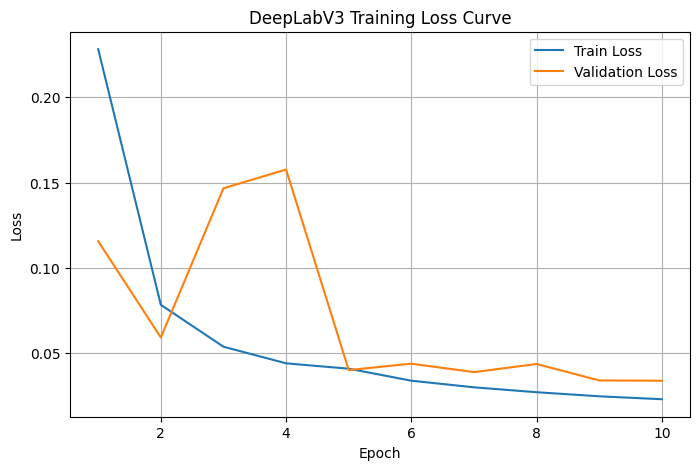

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset and split into train/val
dataset = EgoHandsSegmentationDataset("/kaggle/working/processed_egohands")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Load DeepLabV3
model = deeplabv3_resnet101(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)  # binary segmentation
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

# Save model
torch.save(model.state_dict(), "/kaggle/working/deeplabv3_egohands.pth")
print(" Model saved.")

#  Plot loss graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DeepLabV3 Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import os
import json
import cv2
import torch
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101

# Paths
video_root = "/kaggle/input/wlasl-processed/videos"
json_path = "/kaggle/input/wlasl-processed/WLASL_v0.3.json"
output_root = "/kaggle/working/wlasl_segmented_random"
os.makedirs(output_root, exist_ok=True)

# Step 1: Parse WLASL_v0.3.json and randomly select 50 glosses
with open(json_path, 'r') as f:
    wlasl_data = json.load(f)

# Random 50 glosses
all_glosses = sorted({entry["gloss"] for entry in wlasl_data})
random.seed(42)
selected_glosses = random.sample(all_glosses, 50)

# Build video_id → gloss mapping (only for selected glosses)
video_to_gloss = {}
for entry in wlasl_data:
    if entry["gloss"] not in selected_glosses:
        continue
    for instance in entry["instances"]:
        vid = instance["video_id"]
        video_to_gloss[vid] = entry["gloss"]

print(f"✅ Selected glosses ({len(selected_glosses)}):", selected_glosses[:5])

# Step 2: Load trained DeepLabV3 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = deeplabv3_resnet101(pretrained=False)
model.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=1)

# Load your trained EgoHands model
state_dict = torch.load("/kaggle/working/deeplabv3_egohands.pth", map_location=device)
model.load_state_dict(state_dict, strict=False)
model.eval().to(device)

# Step 3: Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Step 4: Process videos
for vid_file in tqdm(sorted(os.listdir(video_root))):
    if not vid_file.endswith(".mp4"):
        continue

    video_id = os.path.splitext(vid_file)[0]
    gloss = video_to_gloss.get(video_id)
    if gloss is None:
        continue

    gloss_dir = os.path.join(output_root, gloss)
    os.makedirs(gloss_dir, exist_ok=True)

    cap = cv2.VideoCapture(os.path.join(video_root, vid_file))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < 1:
        continue

    # Sample 20 frames from middle 60%
    start = int(0.2 * total_frames)
    end = int(0.8 * total_frames)
    frame_indices = np.linspace(start, end, 20).astype(int)

    saved_count = 0
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb = cv2.resize(rgb, (256, 256))
        pil_img = Image.fromarray(rgb)
        input_tensor = transform(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)['out'][0].argmax(0).cpu().numpy()

        # Only save frame if hand mask is large enough
        if np.count_nonzero(output == 1) > 5000:
            mask = (output == 1).astype(np.uint8) * 255
            hand = cv2.bitwise_and(rgb, rgb, mask=mask)
            save_path = os.path.join(gloss_dir, f"{video_id}_frame_{saved_count:02d}.jpg")
            cv2.imwrite(save_path, cv2.cvtColor(hand, cv2.COLOR_RGB2BGR))
            saved_count += 1

    cap.release()

print("Done: Segmented frames saved into gloss-labeled folders.")


✅ Selected glosses (50): ['position', 'bracelet', 'alligator', 'sculpture', 'drama']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 203MB/s] 
/tmp/ipykernel_137/1341055378.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during u

Done: Segmented frames saved into gloss-labeled folders.


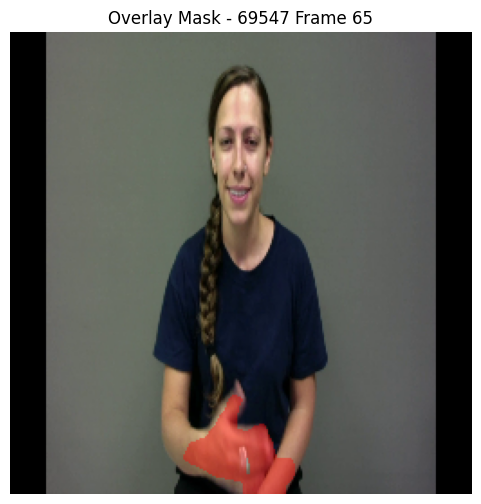

In [9]:
overlay = rgb.copy()
red_mask = np.zeros_like(rgb)
red_mask[:, :, 0] = 255  # Red channel only

binary_mask = (output == 1).astype(np.uint8)
alpha = 0.4  # Transparency

overlay[binary_mask == 1] = cv2.addWeighted(overlay, 1 - alpha, red_mask, alpha, 0)[binary_mask == 1]

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title(f"Overlay Mask - {video_id} Frame {idx}")
plt.axis('off')
plt.show()


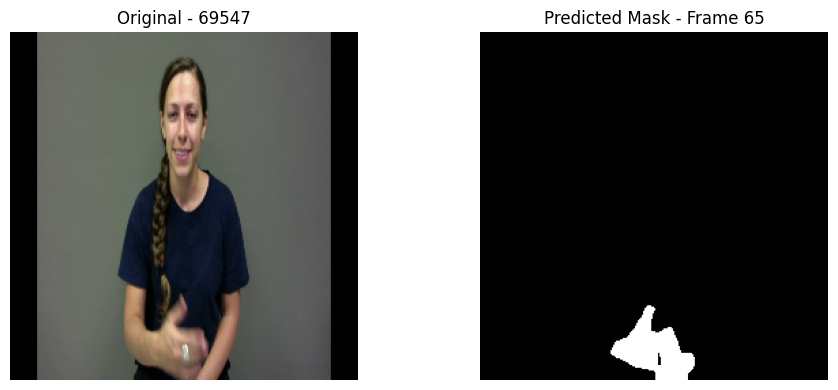

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.title(f"Original - {video_id}")
plt.axis('off')

# Show mask
plt.subplot(1, 2, 2)
plt.imshow(output, cmap="gray")
plt.title(f"Predicted Mask - Frame {idx}")
plt.axis('off')

plt.tight_layout()
plt.show()


Detected 41 glosses.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s] 


Epoch 1/10 | Train Acc: 46.30% | Val Acc: 72.84%
Epoch 2/10 | Train Acc: 94.91% | Val Acc: 90.74%
Epoch 3/10 | Train Acc: 97.38% | Val Acc: 93.21%
Epoch 4/10 | Train Acc: 99.38% | Val Acc: 95.06%
Epoch 5/10 | Train Acc: 100.00% | Val Acc: 95.68%
Epoch 6/10 | Train Acc: 100.00% | Val Acc: 95.68%
Epoch 7/10 | Train Acc: 100.00% | Val Acc: 95.68%
Epoch 8/10 | Train Acc: 100.00% | Val Acc: 95.68%
Epoch 9/10 | Train Acc: 100.00% | Val Acc: 95.68%
Epoch 10/10 | Train Acc: 100.00% | Val Acc: 95.68%
✅ Model saved as resnet18_wlasl_segmented.pth


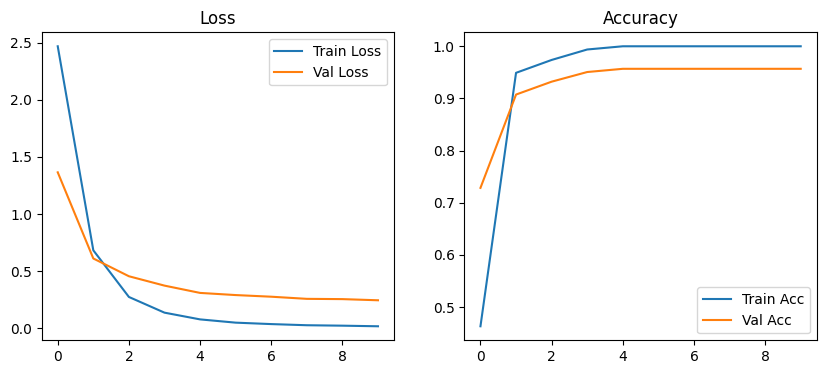

In [18]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

# Paths
data_root = "/kaggle/working/wlasl_segmented_random"

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_root, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)
print(f"Detected {num_classes} glosses.")

# Train-validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Acc: {train_accs[-1]*100:.2f}% | "
          f"Val Acc: {val_accs[-1]*100:.2f}%")

# Save model
torch.save(model.state_dict(), "/kaggle/working/resnet18_wlasl_segmented.pth")
print(" Model saved as resnet18_wlasl_segmented.pth")

# Plot results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.show()


📊 Classification Report (only used classes):
              precision    recall  f1-score   support

      action       1.00      1.00      1.00         6
   alligator       1.00      1.00      1.00         3
       alone       1.00      1.00      1.00         5
    amputate       1.00      1.00      1.00         4
       angel       1.00      1.00      1.00        11
     benefit       1.00      0.83      0.91         6
        bird       1.00      1.00      1.00         5
    bracelet       1.00      1.00      1.00         8
       candy       1.00      1.00      1.00         2
     chapter       1.00      1.00      1.00         3
      cheese       1.00      1.00      1.00         4
     contact       1.00      1.00      1.00         4
       crazy       1.00      1.00      1.00         3
        cute       1.00      1.00      1.00         3
      desert       1.00      1.00      1.00        14
       drama       1.00      1.00      1.00         1
       drive       0.00      0.00   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


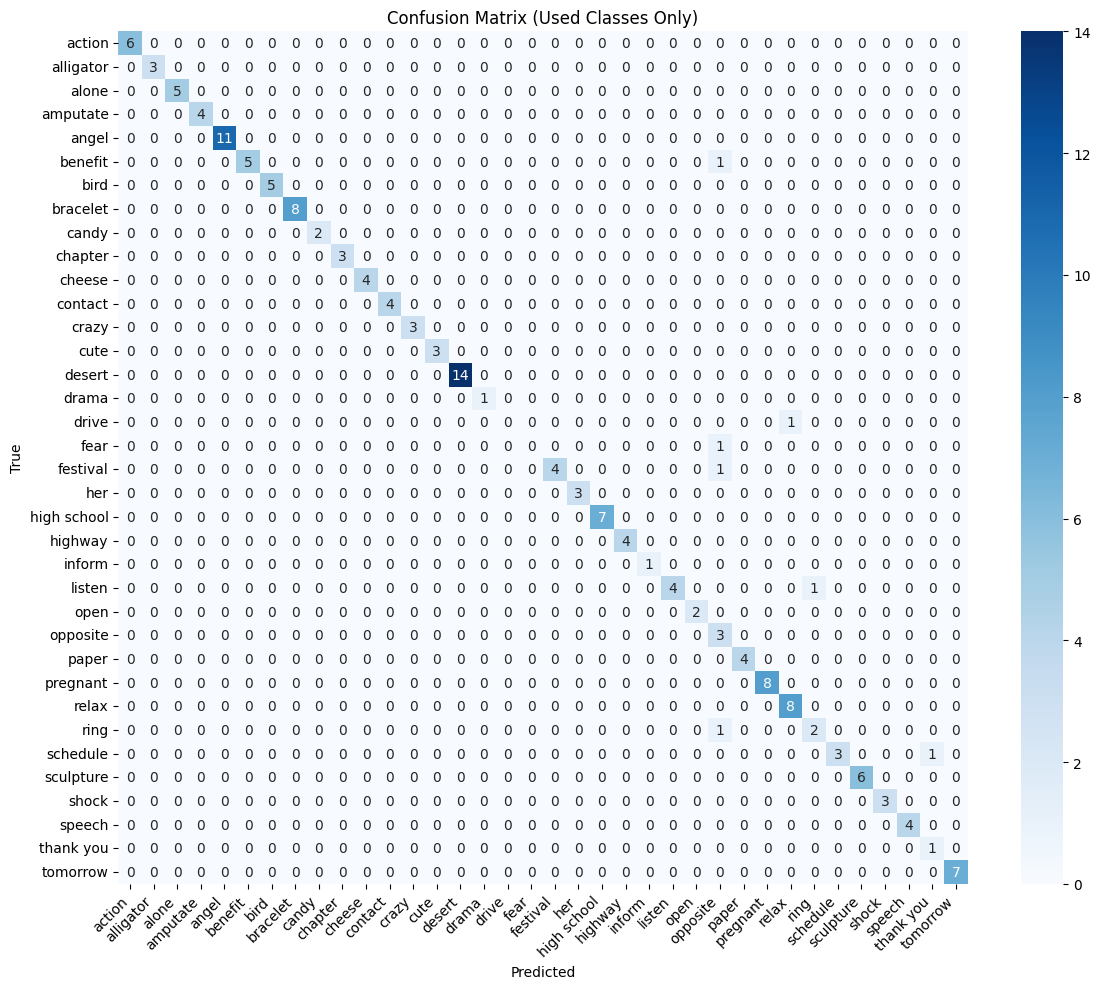

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()

# Step 1: Get all predictions + labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Step 2: Only use labels that actually appear
used_labels = sorted(set(all_labels + all_preds))
class_names = dataset.classes
class_names_used = [class_names[i] for i in used_labels]

# Step 3: Classification report
print("📊 Classification Report (only used classes):")
print(classification_report(
    all_labels,
    all_preds,
    labels=used_labels,
    target_names=class_names_used
))

# Step 4: Confusion matrix (only for used labels)
cm = confusion_matrix(all_labels, all_preds, labels=used_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names_used,
            yticklabels=class_names_used,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Used Classes Only)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [28]:
!pip install torchcam -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is inc

[0] image_np_bgr shape: (224, 224, 3), dtype: uint8
[0] heatmap_color shape: (224, 7, 3), dtype: uint8
[1] image_np_bgr shape: (224, 224, 3), dtype: uint8
[1] heatmap_color shape: (224, 7, 3), dtype: uint8
[2] image_np_bgr shape: (224, 224, 3), dtype: uint8
[2] heatmap_color shape: (224, 7, 3), dtype: uint8
[3] image_np_bgr shape: (224, 224, 3), dtype: uint8
[3] heatmap_color shape: (224, 7, 3), dtype: uint8
[4] image_np_bgr shape: (224, 224, 3), dtype: uint8
[4] heatmap_color shape: (224, 7, 3), dtype: uint8


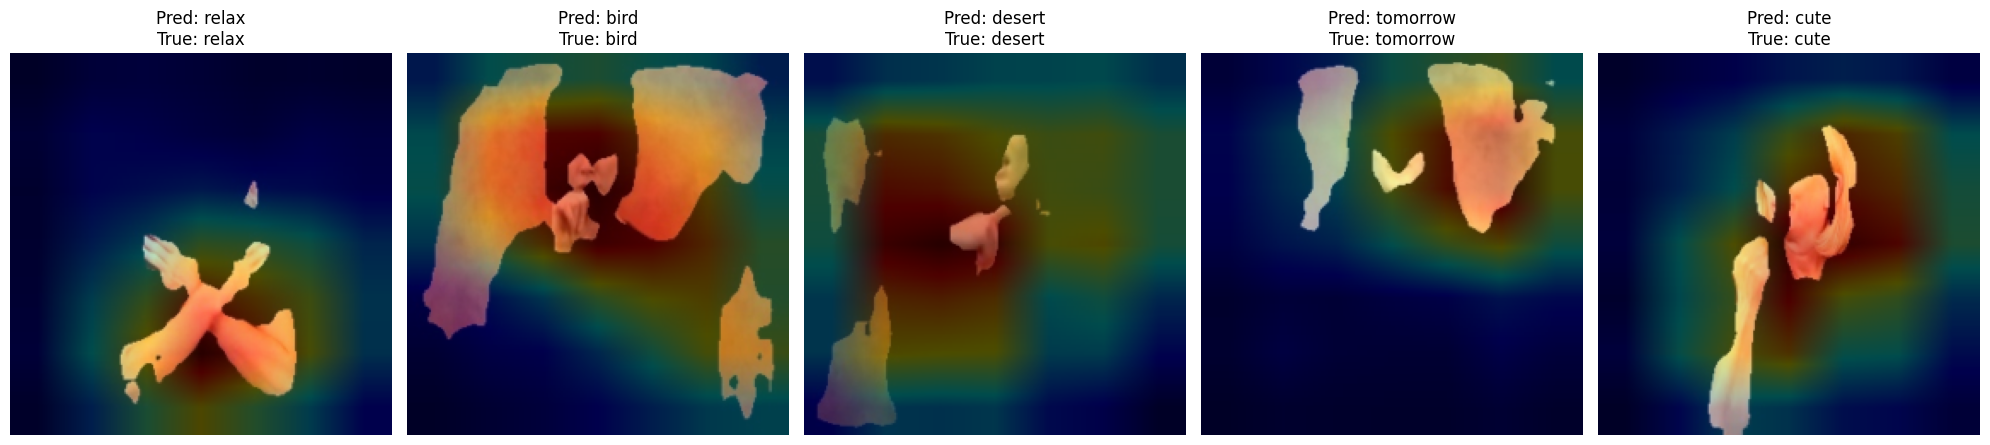

In [56]:
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

# Setup
model.eval()
cam_extractor = SmoothGradCAMpp(model, target_layer="layer4")

# Pick 5 random validation samples
sample_indices = random.sample(range(len(val_ds)), 5)
plt.figure(figsize=(20, 5))

for i, idx in enumerate(sample_indices):
    image, label = val_ds[idx]
    input_tensor = image.unsqueeze(0).to(device)

    # Forward pass (no torch.no_grad())
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

    # 🔥 Get Grad-CAM heatmap
    activation_map = cam_extractor(pred_class, output)[0].cpu().numpy()

    # Prepare original image
    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)
    image_np = (image_np * 255).astype(np.uint8)
    image_np_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    image_np_bgr = cv2.resize(image_np_bgr, (224, 224))

    # Prepare heatmap
    heatmap = cv2.resize(activation_map, (224, 224))
    if heatmap.ndim > 2:
        heatmap = heatmap[0]
    heatmap = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-6)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay: lighter for clarity
    #  Debug: print shape and dtype
    print(f"[{i}] image_np_bgr shape: {image_np_bgr.shape}, dtype: {image_np_bgr.dtype}")
    print(f"[{i}] heatmap_color shape: {heatmap_color.shape}, dtype: {heatmap_color.dtype}")
    
    #  Resize heatmap to match image (just in case)
    heatmap_color = cv2.resize(heatmap_color, (image_np_bgr.shape[1], image_np_bgr.shape[0]))
    
    #  Overlay: ensure both are same shape and type
    overlay = cv2.addWeighted(image_np_bgr, 0.7, heatmap_color, 0.3, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Plot result
    plt.subplot(1, 5, i + 1)
    plt.imshow(overlay_rgb)
    plt.title(f"Pred: {class_names[pred_class]}\nTrue: {class_names[label]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [66]:
!pip install transformers --quiet
!apt-get install -y fonts-noto fonts-noto-unhinted fonts-noto-core fonts-noto-ui-core fonts-noto-color-emoji > /dev/null


In [58]:
from transformers import pipeline

# Load English → Hindi translation pipeline
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-hi")


2025-05-05 04:27:17.044712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746419237.235214     137 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746419237.287275     137 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/306M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


In [59]:
def translate_gloss_to_hindi(gloss):
    # Wrap the gloss in a simple sentence
    wrapped = f"This is a sign for {gloss}."
    
    try:
        result = translator(wrapped)
        hindi_full = result[0]['translation_text']
    except Exception as e:
        print("Translation error:", e)
        return "[अनुवाद विफल]"

    # Try extracting the last meaningful word (optional)
    words = hindi_full.strip().replace("।", "").split()
    hindi_word = words[-1] if words else hindi_full
    return hindi_word


In [79]:
#  Install Devanagari-compatible fonts
!apt-get -y install fonts-noto-core fonts-noto-unhinted fonts-noto fonts-noto-ui-core > /dev/null


In [74]:
import re

def translate_gloss_to_hindi(gloss):
    try:
        result = translator(gloss)
        hindi_raw = result[0]['translation_text'].strip()
        
        # Extract all Devanagari words
        words = re.findall(r'[\u0900-\u097F]+', hindi_raw)

        # Return the first meaningful word, fallback to full sentence
        if words:
            return words[0]
        else:
            return hindi_raw
    except Exception as e:
        print(f"❌ Translation error for '{gloss}':", e)
        return "[अनुवाद विफल]"


In [78]:
translate_gloss_to_hindi("inform") 



'सूचित'

Device set to use cuda:0
/tmp/ipykernel_137/3412528747.py:81: UserWarning: Glyph 108 (l) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_137/3412528747.py:81: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout()


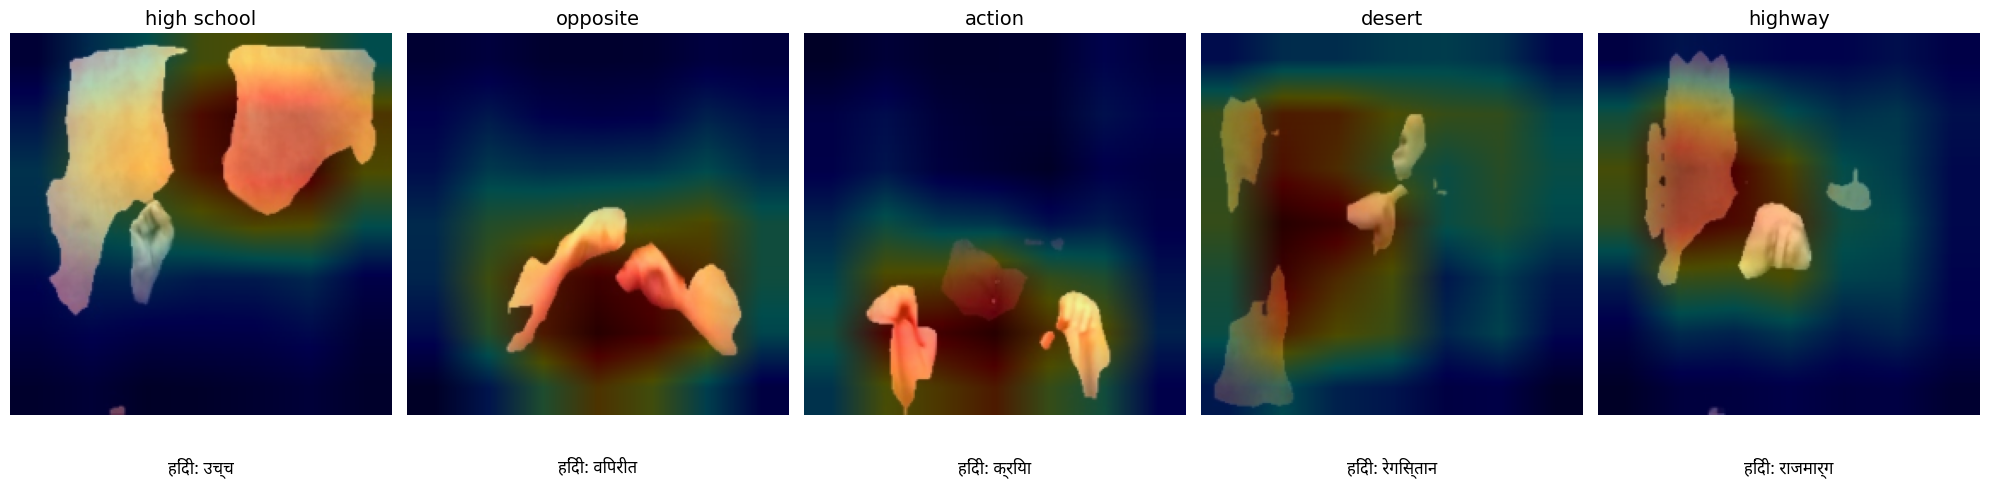

In [91]:
# Imports
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms.functional import to_pil_image
from transformers import pipeline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import torch
import cv2
import numpy as np
import random
import re

# Setup font for Devanagari rendering
font_path = "/usr/share/fonts/truetype/noto/NotoSansDevanagari-Regular.ttf"
hindi_font = fm.FontProperties(fname=font_path)

# Load translation model
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-hi")

def translate_gloss_to_hindi(gloss):
    """Translate gloss to Hindi and extract the most meaningful word."""
    try:
        result = translator(gloss)
        hindi_raw = result[0]['translation_text'].strip()
        words = re.findall(r'[\u0900-\u097F]+', hindi_raw)
        return words[0] if words else hindi_raw
    except Exception as e:
        print(f"❌ Translation error for '{gloss}':", e)
        return "[अनुवाद विफल]"

# Setup model and Grad-CAM
model.eval()
cam_extractor = SmoothGradCAMpp(model, target_layer="layer4")

# Sample 5 random validation samples
sample_indices = random.sample(range(len(val_ds)), 5)
plt.figure(figsize=(20, 6))

for i, idx in enumerate(sample_indices):
    image, label = val_ds[idx]
    input_tensor = image.unsqueeze(0).to(device)

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    gloss = class_names[pred_class]
    hindi = translate_gloss_to_hindi(gloss)

    # Get Grad-CAM activation map
    activation_map = cam_extractor(pred_class, output)[0].cpu().numpy()

    # Convert image to uint8 RGB
    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)
    image_np = (image_np * 255).astype(np.uint8)
    image_np_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    image_np_bgr = cv2.resize(image_np_bgr, (224, 224))

    # Grad-CAM heatmap preparation
    heatmap = cv2.resize(activation_map, (224, 224))
    if heatmap.ndim > 2:
        heatmap = heatmap[0]
    heatmap = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-6)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_color = cv2.resize(heatmap_color, (224, 224))

    # Blend Grad-CAM with original image
    overlay = cv2.addWeighted(image_np_bgr, 0.7, heatmap_color, 0.3, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Plot result
    ax = plt.subplot(1, 5, i + 1)
    ax.imshow(overlay_rgb)
    ax.set_title(f"{gloss}", fontsize=14)
    ax.text(0.5, -0.15, f"हिंदी: {hindi}", fontproperties=hindi_font,
            fontsize=12, ha='center', transform=ax.transAxes)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [96]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers import pipeline
import re
import numpy as np

#  Load translation pipeline
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-hi")

#  Hindi reference dictionary
reference_dict = {
    "action": "क्रिया",
    "alligator": "घड़ियाल",
    "alone": "अकेला",
    "amputate": "अंगविच्छेद",
    "angel": "देवदूत",
    "benefit": "लाभ",
    "bird": "पक्षी",
    "bracelet": "कंगन",
    "candy": "मिठाई",
    "chapter": "अध्याय",
    "cheese": "पनीर",
    "contact": "संपर्क",
    "crazy": "पागल",
    "cute": "प्यारा",
    "desert": "रेगिस्तान",
    "drama": "नाटक",
    "drive": "चालना",
    "fear": "डर",
    "festival": "त्यौहार",
    "her": "उसकी",
    "high school": "उच्च स्कूल",
    "highway": "राजमार्ग",
    "inform": "सूचित",
    "listen": "सुनना",
    "open": "खोलना",
    "opposite": "विपरीत",
    "paper": "कागज़",
    "pregnant": "गर्भवती",
    "relax": "आराम",
    "ring": "अंगूठी",
    "schedule": "समय सारिणी",
    "sculpture": "प्रतिमा",
    "shock": "आघात",
    "speech": "भाषण",
    "thank you": "धन्यवाद",
    "tomorrow": "कल"
}

# Metrics
exact_match = 0
bleu_scores = []
total = 0

smoothie = SmoothingFunction().method1

print("\n📊 Translation Evaluation:\n")

for gloss, true_hindi in reference_dict.items():
    try:
        result = translator(gloss)
        translated = result[0]['translation_text'].strip()
    except Exception as e:
        print(f"Translation error for {gloss}: {e}")
        continue

    # Extract Devanagari words
    pred_words = re.findall(r'[\u0900-\u097F]+', translated)
    ref_words = re.findall(r'[\u0900-\u097F]+', true_hindi)

    bleu = sentence_bleu(
        [ref_words],
        pred_words,
        weights=(1.0, 0, 0, 0),  # BLEU-1 only
        smoothing_function=smoothie
    ) if pred_words else 0

    bleu_scores.append(bleu)
    total += 1

    exact = pred_words[0] == ref_words[0] if (pred_words and ref_words) else False
    if exact:
        exact_match += 1

    print(f"Gloss: {gloss}")
    print(f"Ref : {true_hindi}")
    print(f"Pred: {translated}")
    print(f"Exact Match: {exact}")
    print(f"BLEU-1 Score: {bleu:.2f}")
    print("—" * 40)

# Final results
print(f"\n Exact Matches: {exact_match}/{total} → {exact_match / total:.2%}")
print(f" Avg BLEU-1 Score: {np.mean(bleu_scores):.2f}")


Device set to use cuda:0



📊 Translation Evaluation:

Gloss: action
Ref : क्रिया
Pred: क्रिया
Exact Match: True
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: alligator
Ref : घड़ियाल
Pred: machoghano. kgm
Exact Match: False
BLEU-1 Score: 0.00
————————————————————————————————————————
Gloss: alone
Ref : अकेला
Pred: अकेले
Exact Match: False
BLEU-1 Score: 0.00
————————————————————————————————————————
Gloss: amputate
Ref : अंगविच्छेद
Pred: तैयार किया जा रहा है
Exact Match: False
BLEU-1 Score: 0.00
————————————————————————————————————————
Gloss: angel
Ref : देवदूत
Pred: स्वर्गदूत
Exact Match: False
BLEU-1 Score: 0.00
————————————————————————————————————————
Gloss: benefit
Ref : लाभ
Pred: लाभ
Exact Match: True
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: bird
Ref : पक्षी
Pred: पक्षी
Exact Match: True
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: bracelet
Ref : कंगन
Pred: रंग: (l)
Exact Match: False
BLEU-1 Score: 0.00
———————————————————————————————————————